Initial explanation about the project.

Since our dataset is already preprocessed we can just simply import the desired tools and load the data.

In [148]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE


dataframe = pd.read_csv('data.csv')

dropout_cnt = dataframe['Target'].value_counts().get('Dropout', 0)
enrolled_cnt = dataframe['Target'].value_counts().get('Enrolled', 0)
graduate_cnt = dataframe['Target'].value_counts().get('Graduate', 0)
total_cnt = graduate_cnt + enrolled_cnt + dropout_cnt



Now we set our X and Y axis.

In [149]:
x_axis = dataframe.drop('Target', axis=1)
y_axis = dataframe['Target']

Now we split our data between training and testing.

In [150]:
x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.2, random_state=40)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=40)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train_encoded)

The next step is to train our model.

In [151]:


target_weights = {
# Dropout = 0
    0 : (total_cnt/(3*dropout_cnt)),
# Enrolled = 1
    1 : (total_cnt/(3*enrolled_cnt)),
# Graduate = 2
    2 : (total_cnt/(3*graduate_cnt))
}

start_train = time.time()
clf = DecisionTreeClassifier(class_weight=target_weights,random_state=40)
clf.fit(x_train_resampled, y_train_resampled)
end_train = time.time()

We test our Decision Tree with the X axis test data.

In [152]:
start_test = time.time()
y_pred = clf.predict(x_test)
end_test = time.time()

Finally we check wether our Decision Tree was sucessful or not and categorize it in several metrics.

Acuracy: 0.6746
Precision: 0.6873
Recall: 0.6746
F1-Score: 0.6800
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       287
           1       0.40      0.48      0.44       169
           2       0.77      0.74      0.75       429

    accuracy                           0.67       885
   macro avg       0.63      0.64      0.63       885
weighted avg       0.69      0.67      0.68       885

Training time: 0.1439 seconds
Testing time: 0.0030 seconds


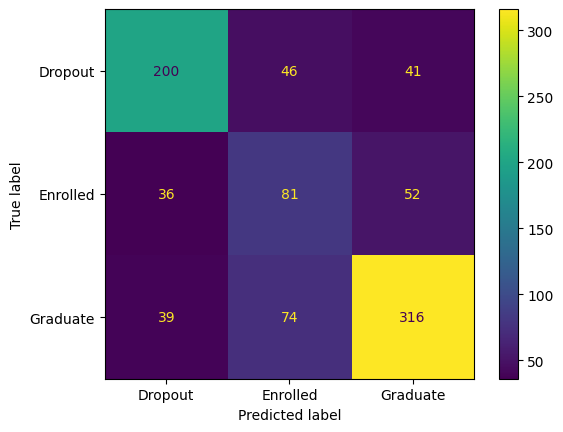

In [153]:
accuracy = skl.metrics.accuracy_score(y_test_encoded, y_pred)
precision = skl.metrics.precision_score(y_test_encoded, y_pred, average="weighted", zero_division=0)
recal = skl.metrics.recall_score(y_test_encoded, y_pred, average="weighted", zero_division=0)
f1_score = skl.metrics.f1_score(y_test_encoded, y_pred, average="weighted", zero_division=0)
confusion_matrix = skl.metrics.confusion_matrix(y_test_encoded,y_pred)


print(f"Acuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recal:.4f}")
print(f"F1-Score: {f1_score:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test_encoded,y_pred, zero_division=0))
print(f"Training time: {end_train-start_train:.4f} seconds")
print(f"Testing time: {end_test-start_test:.4f} seconds")



Here's the visual representation of the Decision Tree.

In [154]:
# plt.figure(figsize=(16,10))
# skl.tree.plot_tree(clf, filled=True, feature_names=x_axis.columns, class_names=True)
# plt.title("Decision Tree Visualization")
# plt.show()